In [232]:
from pykrx import stock
import pandas as pd
import mplfinance as mpf
import numpy as np
import plotly.graph_objects as go
import plotly.subplots as ms
import plotly.express as px

In [233]:
# pip install pykrx
# pip install mplfinance

In [234]:
# 전체 종목코드와 종목명 가져오기
stock_list = pd.DataFrame({'종목코드':stock.get_market_ticker_list(market="ALL")})
stock_list['종목명'] = stock_list['종목코드'].map(lambda x: stock.get_market_ticker_name(x))

In [235]:
name_list = list(stock_list['종목명'])

dff = pd.DataFrame()
stock_from = "20210702" # 2249~2301
stock_to = "20220701"

for name in name_list:
    stock_name = name
    ticker = stock_list.loc[stock_list['종목명']== stock_name, '종목코드']
    df = stock.get_market_ohlcv_by_date(fromdate=stock_from, todate=stock_to, ticker=ticker)
# 칼럼명을 영문명으로 변경
    df['name'] = name
    df["종가"]=df["종가"].apply(pd.to_numeric,errors="coerce")
    dff = pd.concat([dff,df])
dff = dff.rename(columns={'시가':'Open', '고가':'High', '저가':'Low', '종가':'Close', '거래량':'Volume'})

In [236]:
dff

,Open,High,Low,Close,Volume,name
날짜,,,,,,
2021-07-02,3110,3250,3105,3155,394731,3S
2021-07-05,3155,3180,3100,3150,139527,3S
2021-07-06,3150,3150,3090,3120,160550,3S
2021-07-07,3130,3130,3065,3100,124051,3S
2021-07-08,3100,3105,3010,3045,160385,3S
...,...,...,...,...,...,...
2022-06-27,6030,6270,6030,6260,11825,힘스
2022-06-28,6160,6290,6160,6290,9326,힘스
2022-06-29,6280,6280,6110,6240,7290,힘스


In [237]:
# 특정 날이 존재하는 종목 리스트 뽑기 
import numpy as np

df = dff

dname = df.loc[stock_from]['name']
dname = list(dname.values)
dff = pd.DataFrame()

for name in dname:
    stock_name = name
    ticker = stock_list.loc[stock_list['종목명']== stock_name, '종목코드']
    df = stock.get_market_ohlcv_by_date(fromdate=stock_from, todate=stock_to, ticker=ticker)
    df = df.assign(종목명=stock_name)
# 칼럼명을 영문명으로 변경
    df["종가"]=df["종가"].apply(pd.to_numeric,errors="coerce")
    dff = pd.concat([dff,df])
dff = dff.rename(columns={'시가':'Open', '고가':'High', '저가':'Low', '종가':'Close', '거래량':'Volume'})

In [238]:
# # 시가 총액 별 분류 

# market_cap = stock.get_market_cap(stock_to)
# #top_100 = market_cap[0:100] # 상위100
# top_100 = market_cap[-100:] # 하위100
# # top_100 = market_cap[1280:1380] # 중간 100개
# top_100 = top_100.reset_index(drop=False, inplace = False)
# top_100.rename(columns = {"티커" : "종목코드"}, inplace = True)

# stock_100 = pd.merge(top_100, stock_list, how="left", on="종목코드")

# dff = pd.merge(stock_100, dff, how="left", on="종목명")

# # 지표 데이터 프레임 만들기
# df = dff

In [239]:
# 지표 데이터 프레임 만들기
df = dff

df['ma20'] = df['Close'].rolling(window=20).mean() # 20일 이동평균
df['stddev'] = df['Close'].rolling(window=20).std() # 20일 이동표준편차
df['upper'] = df['ma20'] + 2*df['stddev'] # 상단밴드
df['lower'] = df['ma20'] - 2*df['stddev'] # 하단밴드

df['ma12'] = df['Close'].rolling(window=12).mean() # 12일 이동평균
df['ma26'] = df['Close'].rolling(window=26).mean() # 26일 이동평균
df['MACD'] = df['ma12'] - df['ma26']    # MACD
df['MACD_Signal'] = df['MACD'].rolling(window=9).mean() # MACD Signal(MACD 9일 이동평균)
df['MACD_Oscil'] = df['MACD'] - df['MACD_Signal']   #MACD 오실레이터

df['ndays_high'] = df['High'].rolling(window=14, min_periods=1).max()    # 14일 중 최고가
df['ndays_low'] = df['Low'].rolling(window=14, min_periods=1).min()      # 14일 중 최저가
df['fast_k'] = (df['Close'] - df['ndays_low']) / (df['ndays_high'] - df['ndays_low']) * 100  # Fast %K 구하기
df['slow_d'] = df['fast_k'].rolling(window=3).mean()    # Slow %D 구하기

#RSI 구하기
U = np.where(df['Close'].diff(1) > 0, df['Close'].diff(1), 0)
D = np.where(df['Close'].diff(1) < 0, df['Close'].diff(1) *(-1), 0)
AU = pd.DataFrame(U, index=df.index).rolling(window=14).mean()
AD = pd.DataFrame(D, index=df.index).rolling(window=14).mean()
RSI = AU / (AD+AU) *100
df['RSI'] = RSI

# cci 구하기
df['M'] = 0.0
df['m'] = 0.0
df['D'] = 0.0
df['CCI'] = 0.0

df['M'] = (df['High']+df['Low']+df['Close'])/3

df['m'] = df['M'].rolling(window=20).mean()
df['D'] = abs(df['M'] - df['m']).rolling(window=20).mean() # abs
df['CCI'] = (df['M']-df['m'])/(0.015*df['D'])

df

,Open,High,Low,Close,Volume,종목명,ma20,stddev,upper,lower,...,MACD_Oscil,ndays_high,ndays_low,fast_k,slow_d,RSI,M,m,D,CCI
날짜,,,,,,,,,,,,,,,,,,,,,
2021-07-02,3110,3250,3105,3155,394731,3S,NaN,NaN,NaN,NaN,...,NaN,3250.0,3105.0,34.482759,NaN,NaN,3170.000000,NaN,NaN,NaN
2021-07-05,3155,3180,3100,3150,139527,3S,NaN,NaN,NaN,NaN,...,NaN,3250.0,3100.0,33.333333,NaN,NaN,3143.333333,NaN,NaN,NaN
2021-07-06,3150,3150,3090,3120,160550,3S,NaN,NaN,NaN,NaN,...,NaN,3250.0,3090.0,18.750000,28.855364,NaN,3120.000000,NaN,NaN,NaN
2021-07-07,3130,3130,3065,3100,124051,3S,NaN,NaN,NaN,NaN,...,NaN,3250.0,3065.0,18.918919,23.667417,NaN,3098.333333,NaN,NaN,NaN
2021-07-08,3100,3105,3010,3045,160385,3S,NaN,NaN,NaN,NaN,...,NaN,3250.0,3010.0,14.583333,17.417417,NaN,3053.333333,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-27,6030,6270,6030,6260,11825,힘스,7186.0,816.671034,8819.342068,5552.657932,...,-306.267806,8090.0,5650.0,25.000000,16.898409,16.793893,6186.666667,7192.333333,638.825000,-104.949625
2022-06-28,6160,6290,6160,6290,9326,힘스,7101.5,817.623481,8736.746962,5466.253038,...,-297.934473,8000.0,5650.0,27.234043,22.602604,17.803030,6246.666667,7105.500000,667.275000,-85.805036
2022-06-29,6280,6280,6110,6240,7290,힘스,7015.0,812.400600,8639.801201,5390.198799,...,-267.998575,7900.0,5650.0,26.222222,26.152088,18.076923,6210.000000,7018.333333,694.308333,-77.615213


In [240]:
# 보조지표 계산에 필요한 NAN값 제거 
df = df.reset_index(drop=False, inplace = False)

a = [0]*38
b = [1]*(len(df[df['종목명'] == df['종목명'][5]])-38) # dname[0]말고 d
print(b)
c = (a+b)*len(dname)
c = pd.DataFrame(c)

df['bool'] = c
df = df[df['bool'] == 1]

df = df.reset_index(drop=False, inplace = False)
df

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


,index,날짜,Open,High,Low,Close,Volume,종목명,ma20,stddev,...,ndays_high,ndays_low,fast_k,slow_d,RSI,M,m,D,CCI,bool
0,38,2021-08-26,3350,3380,3305,3380,154459,3S,3522.25,265.223218,...,3945.0,3075.0,35.057471,30.487289,34.519573,3355.000000,3516.666667,306.312500,-35.185563,1
1,39,2021-08-27,3380,3575,3325,3465,631108,3S,3533.25,257.571017,...,3945.0,3075.0,44.827586,36.590038,34.982332,3455.000000,3527.250000,304.762500,-15.804657,1
2,40,2021-08-30,3535,3550,3420,3445,264200,3S,3541.50,251.605895,...,3770.0,3075.0,53.237410,44.374156,38.823529,3471.666667,3537.666667,302.133333,-14.563107,1
3,41,2021-08-31,3445,3480,3365,3445,180374,3S,3521.75,242.271460,...,3720.0,3075.0,57.364341,51.809779,40.573770,3430.000000,3524.916667,281.220833,-22.501099,1
4,42,2021-09-01,3445,3530,3410,3490,161173,3S,3499.75,222.411869,...,3720.0,3075.0,64.341085,58.314279,45.762712,3476.666667,3503.333333,247.700000,-7.177141,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521867,617209,2022-06-27,6030,6270,6030,6260,11825,힘스,7186.00,816.671034,...,8090.0,5650.0,25.000000,16.898409,16.793893,6186.666667,7192.333333,638.825000,-104.949625,1
521868,617210,2022-06-28,6160,6290,6160,6290,9326,힘스,7101.50,817.623481,...,8000.0,5650.0,27.234043,22.602604,17.803030,6246.666667,7105.500000,667.275000,-85.805036,1
521869,617211,2022-06-29,6280,6280,6110,6240,7290,힘스,7015.00,812.400600,...,7900.0,5650.0,26.222222,26.152088,18.076923,6210.000000,7018.333333,694.308333,-77.615213,1
521870,617212,2022-06-30,6260,6270,6120,6270,4520,힘스,6926.00,790.245797,...,7600.0,5650.0,31.794872,28.417046,20.080321,6220.000000,6927.833333,722.558333,-65.308068,1


In [241]:
# 거래량 0인적 있는 데이터 제거 

name_list = list(df[df['Volume'] == 0]['종목명'].unique())

# name_list는 volume = 0 인적 잇는것들 
for n in name_list:
    df = df[df['종목명'] != n ]
    
#df = df.reset_index(drop=False, inplace = False)
df

,index,날짜,Open,High,Low,Close,Volume,종목명,ma20,stddev,...,ndays_high,ndays_low,fast_k,slow_d,RSI,M,m,D,CCI,bool
0,38,2021-08-26,3350,3380,3305,3380,154459,3S,3522.25,265.223218,...,3945.0,3075.0,35.057471,30.487289,34.519573,3355.000000,3516.666667,306.312500,-35.185563,1
1,39,2021-08-27,3380,3575,3325,3465,631108,3S,3533.25,257.571017,...,3945.0,3075.0,44.827586,36.590038,34.982332,3455.000000,3527.250000,304.762500,-15.804657,1
2,40,2021-08-30,3535,3550,3420,3445,264200,3S,3541.50,251.605895,...,3770.0,3075.0,53.237410,44.374156,38.823529,3471.666667,3537.666667,302.133333,-14.563107,1
3,41,2021-08-31,3445,3480,3365,3445,180374,3S,3521.75,242.271460,...,3720.0,3075.0,57.364341,51.809779,40.573770,3430.000000,3524.916667,281.220833,-22.501099,1
4,42,2021-09-01,3445,3530,3410,3490,161173,3S,3499.75,222.411869,...,3720.0,3075.0,64.341085,58.314279,45.762712,3476.666667,3503.333333,247.700000,-7.177141,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521867,617209,2022-06-27,6030,6270,6030,6260,11825,힘스,7186.00,816.671034,...,8090.0,5650.0,25.000000,16.898409,16.793893,6186.666667,7192.333333,638.825000,-104.949625,1
521868,617210,2022-06-28,6160,6290,6160,6290,9326,힘스,7101.50,817.623481,...,8000.0,5650.0,27.234043,22.602604,17.803030,6246.666667,7105.500000,667.275000,-85.805036,1
521869,617211,2022-06-29,6280,6280,6110,6240,7290,힘스,7015.00,812.400600,...,7900.0,5650.0,26.222222,26.152088,18.076923,6210.000000,7018.333333,694.308333,-77.615213,1
521870,617212,2022-06-30,6260,6270,6120,6270,4520,힘스,6926.00,790.245797,...,7600.0,5650.0,31.794872,28.417046,20.080321,6220.000000,6927.833333,722.558333,-65.308068,1


In [242]:
# df = df.drop(['level_0','index'],axis=1)
df = df.reset_index(drop=False, inplace = False)

In [243]:
df

,level_0,index,날짜,Open,High,Low,Close,Volume,종목명,ma20,...,ndays_high,ndays_low,fast_k,slow_d,RSI,M,m,D,CCI,bool
0,0,38,2021-08-26,3350,3380,3305,3380,154459,3S,3522.25,...,3945.0,3075.0,35.057471,30.487289,34.519573,3355.000000,3516.666667,306.312500,-35.185563,1
1,1,39,2021-08-27,3380,3575,3325,3465,631108,3S,3533.25,...,3945.0,3075.0,44.827586,36.590038,34.982332,3455.000000,3527.250000,304.762500,-15.804657,1
2,2,40,2021-08-30,3535,3550,3420,3445,264200,3S,3541.50,...,3770.0,3075.0,53.237410,44.374156,38.823529,3471.666667,3537.666667,302.133333,-14.563107,1
3,3,41,2021-08-31,3445,3480,3365,3445,180374,3S,3521.75,...,3720.0,3075.0,57.364341,51.809779,40.573770,3430.000000,3524.916667,281.220833,-22.501099,1
4,4,42,2021-09-01,3445,3530,3410,3490,161173,3S,3499.75,...,3720.0,3075.0,64.341085,58.314279,45.762712,3476.666667,3503.333333,247.700000,-7.177141,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462587,521867,617209,2022-06-27,6030,6270,6030,6260,11825,힘스,7186.00,...,8090.0,5650.0,25.000000,16.898409,16.793893,6186.666667,7192.333333,638.825000,-104.949625,1
462588,521868,617210,2022-06-28,6160,6290,6160,6290,9326,힘스,7101.50,...,8000.0,5650.0,27.234043,22.602604,17.803030,6246.666667,7105.500000,667.275000,-85.805036,1
462589,521869,617211,2022-06-29,6280,6280,6110,6240,7290,힘스,7015.00,...,7900.0,5650.0,26.222222,26.152088,18.076923,6210.000000,7018.333333,694.308333,-77.615213,1
462590,521870,617212,2022-06-30,6260,6270,6120,6270,4520,힘스,6926.00,...,7600.0,5650.0,31.794872,28.417046,20.080321,6220.000000,6927.833333,722.558333,-65.308068,1


In [244]:
Base_data = df

Base_data['BOL_trade'] = 0 # 밴드의 상한 및 하한선 벗어날 때
Base_data['MACD_trade'] = 0 # 음->양 매수 양->음 매도 
Base_data['RSI_trade'] = 0 # 70이상 매도 , 30이하 매수 
Base_data['CCI_trade'] = 0 # -100 ->상향 매수, 100 -> 하향 매도 
Base_data['STO_trade'] = 0 # k가 d를 상향 돌파, 매수 / k가 d를 하향 돌파 매도 
#Base_data['MFI_trade'] = 0 # 20이하로 떨어지면 매수 , 80이상으로 가면 매도 

BOL_c = 0
MACD_c = 0
RSI_c = 0
CCI_c = 0
STO_c = 0
#MFI_c = 0


# 볼린저밴드 upper, lower 
# macd = MACD_Oscil
# sto = fast_k, slow_d
# RSI
# CCI

Alpha = 0 
for i in range(len(Base_data)):
    if Alpha == 0:
        if Base_data['CCI'][i] < -100:
            Alpha = -1 
    if Alpha == -1:
        if Base_data['CCI'][i] > -100:
            Base_data['CCI_trade'][i] = 1
            CCI_c += 1
            Alpha = 0
    if Alpha == 0:       
        if Base_data['CCI'][i] > 100:
            Alpha = 1
    if Alpha == 1:
        if Base_data['CCI'][i] < 100:
            Base_data['CCI_trade'][i] = 2
            CCI_c += 1
            Alpha = 0
 
Alpha = 0
for i in range(len(Base_data)):
    if Alpha == 0:
        if Base_data['Close'][i] < Base_data['lower'][i]: # 종가가 하한선보다 작다면 
            Alpha = -1 
    if Base_data['Close'][i] > Base_data['lower'][i]:
        if Alpha == -1:
            Base_data['BOL_trade'][i] = 1
            BOL_c += 1
            Alpha = 0 
            
    if Alpha == 0:
        if Base_data['Close'][i] > Base_data['upper'][i]: # 종가가 하한선보다 크면
            Alpha = 1
    if Base_data['Close'][i] < Base_data['upper'][i]:
        if Alpha == 1:
            Base_data['BOL_trade'][i] = 2
            BOL_c += 1
            Alpha = 0
            
Alpha = 0
for i in range(len(Base_data)):
    if Alpha == 0:
        if Base_data['MACD_Oscil'][i] < 0:
            Alpha = -1
    if Base_data['MACD_Oscil'][i] > 0:
        if Alpha == -1:
            Base_data['MACD_trade'][i] = 1
            MACD_c += 1
            Alpha = 1 # 0
            
    if Alpha == 0:           
        if Base_data['MACD_Oscil'][i] > 0:
            Alpha = 1
    if Base_data['MACD_Oscil'][i] < 0:
        if Alpha == 1:
            Base_data['MACD_trade'][i] = 2
            MACD_c += 1
            Alpha = -1 # 0
            
Alpha = 0
for i in range(len(Base_data)):
    if Alpha == 0:
        if Base_data['RSI'][i] < 30:
            Alpha = -1
    if Base_data['RSI'][i] > 30:
        if Alpha == -1:
            Base_data['RSI_trade'][i] = 1
            RSI_c += 1
            Alpha = 0
    if Alpha == 0:           
        if Base_data['RSI'][i] > 70:
            Alpha = 1 
    if Base_data['RSI'][i] < 70:
        if Alpha == 1:
            Base_data['RSI_trade'][i] = 2
            RSI_c += 1
            Alpha = 0
    
Alpha = 0
for i in range(len(Base_data)):
    if Alpha == 0:
        if Base_data['fast_k'][i] < Base_data['slow_d'][i]:
            Alpha = -1
    if Alpha == -1:
        if Base_data['fast_k'][i] > Base_data['slow_d'][i]:
            Base_data['STO_trade'][i] = 1
            STO_c += 1
            Alpha = 1 # 0 
            
    if Alpha == 0:
        if Base_data['fast_k'][i] > Base_data['slow_d'][i]:
            Alpha = 1
    if Alpha == 1:
        if Base_data['fast_k'][i] < Base_data['slow_d'][i]:
            Base_data['STO_trade'][i] = 2
            STO_c += 1
            Alpha =  -1 # 0

Base_data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to b

,level_0,index,날짜,Open,High,Low,Close,Volume,종목명,ma20,...,M,m,D,CCI,bool,BOL_trade,MACD_trade,RSI_trade,CCI_trade,STO_trade
0,0,38,2021-08-26,3350,3380,3305,3380,154459,3S,3522.25,...,3355.000000,3516.666667,306.312500,-35.185563,1,0,0,0,0,0
1,1,39,2021-08-27,3380,3575,3325,3465,631108,3S,3533.25,...,3455.000000,3527.250000,304.762500,-15.804657,1,0,0,0,0,0
2,2,40,2021-08-30,3535,3550,3420,3445,264200,3S,3541.50,...,3471.666667,3537.666667,302.133333,-14.563107,1,0,0,0,0,0
3,3,41,2021-08-31,3445,3480,3365,3445,180374,3S,3521.75,...,3430.000000,3524.916667,281.220833,-22.501099,1,0,0,0,0,0
4,4,42,2021-09-01,3445,3530,3410,3490,161173,3S,3499.75,...,3476.666667,3503.333333,247.700000,-7.177141,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462587,521867,617209,2022-06-27,6030,6270,6030,6260,11825,힘스,7186.00,...,6186.666667,7192.333333,638.825000,-104.949625,1,0,0,0,0,0
462588,521868,617210,2022-06-28,6160,6290,6160,6290,9326,힘스,7101.50,...,6246.666667,7105.500000,667.275000,-85.805036,1,0,0,0,1,0
462589,521869,617211,2022-06-29,6280,6280,6110,6240,7290,힘스,7015.00,...,6210.000000,7018.333333,694.308333,-77.615213,1,0,0,0,0,0
462590,521870,617212,2022-06-30,6260,6270,6120,6270,4520,힘스,6926.00,...,6220.000000,6927.833333,722.558333,-65.308068,1,0,0,0,0,0


In [245]:
Base_data['MACD_Oscil'].mean()

-17.29653443173949

In [246]:
Base_data[Base_data['종목명'] == '3S']

,level_0,index,날짜,Open,High,Low,Close,Volume,종목명,ma20,...,M,m,D,CCI,bool,BOL_trade,MACD_trade,RSI_trade,CCI_trade,STO_trade
0,0,38,2021-08-26,3350,3380,3305,3380,154459,3S,3522.25,...,3355.000000,3516.666667,306.312500,-35.185563,1,0,0,0,0,0
1,1,39,2021-08-27,3380,3575,3325,3465,631108,3S,3533.25,...,3455.000000,3527.250000,304.762500,-15.804657,1,0,0,0,0,0
2,2,40,2021-08-30,3535,3550,3420,3445,264200,3S,3541.50,...,3471.666667,3537.666667,302.133333,-14.563107,1,0,0,0,0,0
3,3,41,2021-08-31,3445,3480,3365,3445,180374,3S,3521.75,...,3430.000000,3524.916667,281.220833,-22.501099,1,0,0,0,0,0
4,4,42,2021-09-01,3445,3530,3410,3490,161173,3S,3499.75,...,3476.666667,3503.333333,247.700000,-7.177141,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,203,241,2022-06-27,2875,3060,2875,3010,1279405,3S,3067.50,...,2981.666667,3089.000000,180.808333,-39.575364,1,0,0,1,0,1
204,204,242,2022-06-28,2970,3165,2940,3065,2371710,3S,3057.00,...,3056.666667,3080.083333,179.716667,-8.686513,1,0,0,0,0,0
205,205,243,2022-06-29,3370,3590,3160,3230,13970435,3S,3050.00,...,3326.666667,3075.583333,181.387500,92.282483,1,0,0,0,0,0
206,206,244,2022-06-30,3330,3550,3105,3105,19170307,3S,3037.75,...,3253.333333,3070.000000,182.562500,66.948153,1,0,1,0,0,2


In [247]:
print(len(Base_data[Base_data['MACD_trade'] == 1]))
print(len(Base_data[Base_data['MACD_trade'] == 2]))

print(len(Base_data[Base_data['STO_trade'] == 1]))
print(len(Base_data[Base_data['STO_trade'] == 2]))

print(len(Base_data[Base_data['RSI_trade'] == 1]))
print(len(Base_data[Base_data['RSI_trade'] == 2]))

print(len(Base_data[Base_data['CCI_trade'] == 1]))
print(len(Base_data[Base_data['CCI_trade'] == 2]))

print(len(Base_data[Base_data['BOL_trade'] == 1]))
print(len(Base_data[Base_data['BOL_trade'] == 2]))

16456
16456
90016
90016
18954
11589
17084
12515
16384
10279


In [248]:
len(b)

208

In [249]:
trade_data = Base_data

trade_data['BOL_profit']= 0
trade_data['MACD_profit']= 0
trade_data['RSI_profit']= 0
trade_data['CCI_profit']= 0
trade_data['STO_profit']= 0


trade_data['Ori']= 0


# 한 종목 개수 
len_a = len(b)
start_m = 30000000 # 시작 돈 
plus_m = 0 # 월급 

# 0-대기 1-매수 2-매도
def trade(data, asset, indicator):
    day = 0
    ori = 0
    count = 0 
    can_b = 0
    can_s = 0
    for _ in range(len(data)-1):
        if _%len_a == 0:
            day = 0
            ori = 0
            count = 0 
            can_b = 0
            can_s = 0
            asset = start_m
        if day != 0:
            if day%30 == 0:
                ori += 1
                day = 0 
                asset += plus_m
                
        if data[indicator + '_trade'][_] == 0:
            data[indicator + '_profit'][_] = asset + (count*data['Close'][_])
        elif data[indicator + '_trade'][_] == 1:
            can_b = int(asset / data['Open'][_+1])
            asset -= can_b*data['Open'][_+1]
            count += can_b 
            data[indicator + '_profit'][_] = asset + (count*data['Close'][_])
            can_b = 0
        elif data[indicator + '_trade'][_] == 2:
            can_s = int(count)
            asset += can_s*data['Open'][_+1]
            count -= can_s
            data[indicator + '_profit'][_] = asset + (count*data['Close'][_])
            can_s = 0
        data['Ori'][_] = start_m + (ori)*plus_m
        day += 1
    return data

trade_data = trade(trade_data, start_m, "BOL")
trade_data = trade(trade_data, start_m, "MACD")
trade_data = trade(trade_data, start_m, "RSI")
trade_data = trade(trade_data, start_m, "CCI")
trade_data = trade(trade_data, start_m, "STO")



trade_data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to b

,level_0,index,날짜,Open,High,Low,Close,Volume,종목명,ma20,...,MACD_trade,RSI_trade,CCI_trade,STO_trade,BOL_profit,MACD_profit,RSI_profit,CCI_profit,STO_profit,Ori
0,0,38,2021-08-26,3350,3380,3305,3380,154459,3S,3522.25,...,0,0,0,0,30000000,30000000,30000000,30000000,30000000,30000000
1,1,39,2021-08-27,3380,3575,3325,3465,631108,3S,3533.25,...,0,0,0,0,30000000,30000000,30000000,30000000,30000000,30000000
2,2,40,2021-08-30,3535,3550,3420,3445,264200,3S,3541.50,...,0,0,0,0,30000000,30000000,30000000,30000000,30000000,30000000
3,3,41,2021-08-31,3445,3480,3365,3445,180374,3S,3521.75,...,0,0,0,0,30000000,30000000,30000000,30000000,30000000,30000000
4,4,42,2021-09-01,3445,3530,3410,3490,161173,3S,3499.75,...,0,0,0,0,30000000,30000000,30000000,30000000,30000000,30000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462587,521867,617209,2022-06-27,6030,6270,6030,6260,11825,힘스,7186.00,...,0,0,0,0,20937760,21064130,18718860,24912480,23933630,30000000
462588,521868,617210,2022-06-28,6160,6290,6160,6290,9326,힘스,7101.50,...,0,0,1,0,21038080,21064130,18808530,25031850,24048320,30000000
462589,521869,617211,2022-06-29,6280,6280,6110,6240,7290,힘스,7015.00,...,0,0,0,0,20870880,21064130,18659080,24832900,23857170,30000000
462590,521870,617212,2022-06-30,6260,6270,6120,6270,4520,힘스,6926.00,...,0,0,0,0,20971200,21064130,18748750,24952270,23971860,30000000


In [250]:
(len(data[data['종목명'] == data['종목명'][5]]))


161

In [251]:
data = trade_data

len_a = (len(data[data['종목명'] == data['종목명'][5]]))
print(len_a)

win = 0
lose = 0
state = 0
b = 0
s = 0

b_c = 0
m_c = 0
r_c = 0
c_c = 0
s_c = 0
ik = 0
son = 0

for i in range(len(data)):
    if i%len_a == 0:
        state = 0
    if state==0:
        if data['BOL_trade'][i] == 1:
            b = data['Close'][i]
            state = 1
    if state== 1:
        if data['BOL_trade'][i] == 2:
            s = data['Close'][i]  
            state = 0
            b_c += 1 
            if b < s:
                win +=1
                ik += s-b
            else:
                lose+=1
                son += s-b
            # print(b,s)
            b=0
            s=0
        elif data['BOL_trade'][i] == 1:
            # b = data['Close'][i]
            # lose += 1
            state = 1
print(win/(win+lose), son/lose, ik/win)

win = 0
lose = 0
state = 0
b = 0
s = 0
ik = 0
son = 0

for i in range(len(data)):
    if i%len_a == 0:
        state = 0
    if state==0:
        if data['MACD_trade'][i] == 1:
            b = data['Close'][i]
            state = 1
    if state== 1:
        if data['MACD_trade'][i] == 2:
            s = data['Close'][i]  
            state = 0
            m_c += 1 
            if b < s:
                win +=1
                ik += s-b
            else:
                lose+=1
                son += s-b
            b=0
            s=0
        # elif data['MACD_trade'][i] == 1:
        #     # b = data['Close'][i]
        #     # lose += 1
        #     state = 1
print(win/(win+lose),son/lose, ik/win)

win = 0
lose = 0
state = 0
b = 0
s = 0
ik = 0
son = 0
for i in range(len(data)):
    if i%len_a == 0:
        state = 0
    if state==0:
        if data['RSI_trade'][i] == 1:
            b = data['Close'][i]
            state = 1
    if state== 1:
        if data['RSI_trade'][i] == 2:
            s = data['Close'][i]  
            state = 0
            r_c += 1 
            if b < s:
                win +=1
                ik += s-b
            else:
                lose+=1
                son += s-b
            b=0
            s=0
        elif data['RSI_trade'][i] == 1:
            # b = data['Close'][i]
            # lose += 1
            state = 1
print(win/(win+lose), son/lose, ik/win)

win = 0
lose = 0
state = 0
b = 0
s = 0
ik = 0
son = 0
for i in range(len(data)):
    if i%len_a == 0:
        state = 0
    if state==0:
        if data['CCI_trade'][i] == 1:
            b = data['Close'][i]
            state = 1
    if state== 1:
        if data['CCI_trade'][i] == 2:
            s = data['Close'][i]  
            state = 0
            c_c += 1 
            if b < s:
                win +=1
                ik += s-b
            else:
                lose+=1
                son+= s-b
            b=0
            s=0
        elif data['CCI_trade'][i] == 1:
            # b = data['Close'][i]
            # lose += 1
            state = 1
print(win/(win+lose), son/lose, ik/win)


win = 0
lose = 0
state = 0
b = 0
s = 0
ik = 0
son = 0

for i in range(len(data)):
    if i%len_a == 0:
        state = 0
        
    if state==0:
        if data['STO_trade'][i] == 1:
            b = data['Close'][i]
            state = 1
    if state== 1:
        if data['STO_trade'][i] == 2:
            s = data['Close'][i]  
            state = 0
            s_c += 1 
            if b < s:
                win +=1
                ik += (s-b)
            else:
                son += (s-b)
                lose+=1
            b=0
            s=0
        # elif data['STO_trade'][i] == 1:
        #     # b = data['Close'][i]
        #     # lose += 1
        #     state = 1
print(win/(win+lose), son/lose, ik/win)

208
0.6408327062954603 -3317.5342178770948 1988.375733855186
0.31240295633811566 -1639.2464095384337 1983.3395626242545
0.5808483052417114 -3217.83694211224 1883.2882653061224
0.6104559748427673 -3103.181634712412 1787.6461687057308
0.3301860376555447 -593.1246091333211 971.0037652645861


In [252]:
trade_data

,level_0,index,날짜,Open,High,Low,Close,Volume,종목명,ma20,...,MACD_trade,RSI_trade,CCI_trade,STO_trade,BOL_profit,MACD_profit,RSI_profit,CCI_profit,STO_profit,Ori
0,0,38,2021-08-26,3350,3380,3305,3380,154459,3S,3522.25,...,0,0,0,0,30000000,30000000,30000000,30000000,30000000,30000000
1,1,39,2021-08-27,3380,3575,3325,3465,631108,3S,3533.25,...,0,0,0,0,30000000,30000000,30000000,30000000,30000000,30000000
2,2,40,2021-08-30,3535,3550,3420,3445,264200,3S,3541.50,...,0,0,0,0,30000000,30000000,30000000,30000000,30000000,30000000
3,3,41,2021-08-31,3445,3480,3365,3445,180374,3S,3521.75,...,0,0,0,0,30000000,30000000,30000000,30000000,30000000,30000000
4,4,42,2021-09-01,3445,3530,3410,3490,161173,3S,3499.75,...,0,0,0,0,30000000,30000000,30000000,30000000,30000000,30000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462587,521867,617209,2022-06-27,6030,6270,6030,6260,11825,힘스,7186.00,...,0,0,0,0,20937760,21064130,18718860,24912480,23933630,30000000
462588,521868,617210,2022-06-28,6160,6290,6160,6290,9326,힘스,7101.50,...,0,0,1,0,21038080,21064130,18808530,25031850,24048320,30000000
462589,521869,617211,2022-06-29,6280,6280,6110,6240,7290,힘스,7015.00,...,0,0,0,0,20870880,21064130,18659080,24832900,23857170,30000000
462590,521870,617212,2022-06-30,6260,6270,6120,6270,4520,힘스,6926.00,...,0,0,0,0,20971200,21064130,18748750,24952270,23971860,30000000


In [253]:
# 페어 형성된 개수 
print(b_c,m_c,r_c,c_c,s_c)

3987 16101 5399 5088 89283


In [254]:
# 페어 형성된 개수 
print(b_c,m_c,r_c,c_c,s_c)

3987 16101 5399 5088 89283


In [255]:
len(trade_data)

462592

In [256]:
print(len(data[data['BOL_trade']  == 1]), len(data[data['BOL_trade']  == 2]), "BOL",1/((len(data[data['BOL_trade']  == 1])+len(data[data['BOL_trade']  == 2]))/len(data)))


print(len(data[data['MACD_trade']  == 1]), len(data[data['MACD_trade']  == 2]),"MACD",1/((len(data[data['MACD_trade']  == 1])+len(data[data['MACD_trade']  == 2]))/len(data)))


print(len(data[data['RSI_trade']  == 1]), len(data[data['RSI_trade']  == 2]),"RSI",1/((len(data[data['RSI_trade']  == 1])+len(data[data['RSI_trade']  == 2]))/len(data)))


print(len(data[data['CCI_trade']  == 1]), len(data[data['CCI_trade']  == 2]),"CCI",1/((len(data[data['CCI_trade']  == 1])+len(data[data['CCI_trade']  == 2]))/len(data)))


print(len(data[data['STO_trade']  == 1]), len(data[data['STO_trade']  == 2]),"STO",1/((len(data[data['STO_trade']  == 1])+len(data[data['STO_trade']  == 2]))/len(data)))

16384 10279 BOL 17.349585568015602
16456 16456 MACD 14.055420515313562
18954 11589 RSI 15.145598009363848
17084 12515 CCI 15.628636102571033
90016 90016 STO 2.569498755776751


In [257]:
# 맞췄을까? 

trade_data['BOL_bool'] = 0
trade_data['MACD_bool'] = 0
trade_data['RSI_bool'] = 0
trade_data['CCI_bool'] = 0
trade_data['STO_bool'] = 0

trade_data['trend'] = 0 

for _ in range(1, len(trade_data)):
    if _%len_a == 0:
        continue
    if trade_data['Close'][_] - trade_data['Close'][_-1] == 0:
        trade_data['trend'][_] = 0
    elif trade_data['Close'][_] - trade_data['Close'][_-1] > 0:
        trade_data['trend'][_] = 1
    elif trade_data['Close'][_] - trade_data['Close'][_-1] < 0:
        trade_data['trend'][_] = -1
        
# trend가 나왔고, 
def gogo(data, indicator):
    state = 0
    for _ in range(len(data)-1):
        if _%len_a == 0:
            state = 0
        # state check
        if data[indicator + '_trade'][_] == 1:
            state = 1 # 매수 상태 
        elif data[indicator + '_trade'][_] == 2:
            state = 2 # 매도 상태
        # state 별로 값 할당
        
        if state == 0:
            if data[indicator + '_trade'][_] == 0:
                data[indicator + '_bool'][_] = state
        elif state == 1: # 매수 상태
            
            # 1 or -1
            if data['trend'][_] >=0:
                data[indicator + '_bool'][_] = 1
            else:
                data[indicator + '_bool'][_] = -1
        elif state == 2: # 매도 상태
            
            if data['trend'][_] <= 0 :
                data[indicator + '_bool'][_] = 1
            else:
                data[indicator + '_bool'][_] = -1
    return data

gogo(trade_data, 'BOL')
gogo(trade_data, 'MACD')
gogo(trade_data, 'RSI')
gogo(trade_data, 'CCI')
gogo(trade_data, 'STO')


# 1이 맞춘거, -1이 틀린것 

print(len(trade_data[trade_data['BOL_bool'] == 1]))
print(len(trade_data[trade_data['BOL_bool'] == -1]))

print(len(trade_data[trade_data['MACD_bool'] == 1]))
print(len(trade_data[trade_data['MACD_bool'] == -1]))

print(len(trade_data[trade_data['RSI_bool'] == 1]))
print(len(trade_data[trade_data['RSI_bool'] == -1]))

print(len(trade_data[trade_data['CCI_bool'] == 1]))
print(len(trade_data[trade_data['CCI_bool'] == -1]))

print(len(trade_data[trade_data['STO_bool'] == 1]))
print(len(trade_data[trade_data['STO_bool'] == -1]))




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipyk

232746
188740
243411
209091
243108
202480
235275
193064
382511
77302


In [258]:
print(len(trade_data[trade_data['BOL_bool'] == 1]) / (len(trade_data[trade_data['BOL_bool'] == 1])+len(trade_data[trade_data['BOL_bool'] == -1])))
print(len(trade_data[trade_data['BOL_bool'] == 1]))
print(len(trade_data[trade_data['BOL_bool'] == -1]))

print(len(trade_data[trade_data['MACD_bool'] == 1]) / (len(trade_data[trade_data['MACD_bool'] == 1])+len(trade_data[trade_data['MACD_bool'] == -1])))
print(len(trade_data[trade_data['MACD_bool'] == 1]))
print(len(trade_data[trade_data['MACD_bool'] == -1]))

print(len(trade_data[trade_data['RSI_bool'] == 1]) / (len(trade_data[trade_data['RSI_bool'] == 1])+len(trade_data[trade_data['RSI_bool'] == -1])))
print(len(trade_data[trade_data['RSI_bool'] == 1]))
print(len(trade_data[trade_data['RSI_bool'] == -1]))

print(len(trade_data[trade_data['CCI_bool'] == 1]) / (len(trade_data[trade_data['CCI_bool'] == 1])+len(trade_data[trade_data['CCI_bool'] == -1])))
print(len(trade_data[trade_data['CCI_bool'] == 1]))
print(len(trade_data[trade_data['CCI_bool'] == -1]))

print(len(trade_data[trade_data['STO_bool'] == 1]) / (len(trade_data[trade_data['STO_bool'] == 1])+len(trade_data[trade_data['STO_bool'] == -1])))
print(len(trade_data[trade_data['STO_bool'] == 1]))
print(len(trade_data[trade_data['STO_bool'] == -1]))

0.5522033946560503
232746
188740
0.5379224843205113
243411
209091
0.5455891989909961
243108
202480
0.5492728889967993
235275
193064
0.8318838310356601
382511
77302


In [259]:
# 오른 시점은 뺴야함 
BOL_trade = trade_data[trade_data['BOL_trade'] == 0]
print(len(BOL_trade[BOL_trade['BOL_bool'] == 1]) / (len(BOL_trade[BOL_trade['BOL_bool'] == 1])+len(BOL_trade[BOL_trade['BOL_bool'] == -1])))
print(len(BOL_trade[BOL_trade['BOL_bool'] == 1]))
print(len(BOL_trade[BOL_trade['BOL_bool'] == -1]))
print(len(trade_data[trade_data['BOL_trade'] == 0]))

MACD_trade = trade_data[trade_data['MACD_trade'] == 0]
print(len(MACD_trade[MACD_trade['MACD_bool'] == 1]) / (len(MACD_trade[MACD_trade['MACD_bool'] == 1])+len(MACD_trade[MACD_trade['MACD_bool'] == -1])))
print(len(MACD_trade[MACD_trade['MACD_bool'] == 1]))
print(len(MACD_trade[MACD_trade['MACD_bool'] == -1]))
print(len(trade_data[trade_data['MACD_trade'] == 0]))

RSI_trade = trade_data[trade_data['RSI_trade'] == 0]
print(len(RSI_trade[RSI_trade['RSI_bool'] == 1]) / (len(RSI_trade[RSI_trade['RSI_bool'] == 1])+len(RSI_trade[RSI_trade['RSI_bool'] == -1])))
print(len(RSI_trade[RSI_trade['RSI_bool'] == 1]))
print(len(RSI_trade[RSI_trade['RSI_bool'] == -1]))
print(len(trade_data[trade_data['RSI_trade'] == 0]))

CCI_trade = trade_data[trade_data['CCI_trade'] == 0]
print(len(CCI_trade[CCI_trade['CCI_bool'] == 1]) / (len(CCI_trade[CCI_trade['CCI_bool'] == 1])+len(CCI_trade[CCI_trade['CCI_bool'] == -1])))
print(len(CCI_trade[CCI_trade['CCI_bool'] == 1]))
print(len(CCI_trade[CCI_trade['CCI_bool'] == -1]))
print(len(trade_data[trade_data['CCI_trade'] == 0]))

STO_trade = trade_data[trade_data['STO_trade'] == 0]
print(len(STO_trade[STO_trade['STO_bool'] == 1]) / (len(STO_trade[STO_trade['STO_bool'] == 1])+len(STO_trade[STO_trade['STO_bool'] == -1])))
print(len(STO_trade[STO_trade['STO_bool'] == 1]))
print(len(STO_trade[STO_trade['STO_bool'] == -1]))
print(len(trade_data[trade_data['STO_trade'] == 0]))


0.5287052679301865
208745
186078
435929
0.5292309158940871
222060
197530
429680
0.5204568179354045
216013
199032
432049
0.5244068816772834
209102
189638
432993
0.7879019661806913
220440
59341
282560


In [260]:
# 선행지표로서의 승률 
JM = len(trade_data[trade_data['종목명'] == trade_data['종목명'][0]])

BOL_index1 = trade_data.index[trade_data['BOL_trade'] == 1]
BOL_index2 = trade_data.index[trade_data['BOL_trade'] == 2]
BOL_index1 = BOL_index1.to_list()
BOL_index2 = BOL_index2.to_list()

BOL_indexs = BOL_index1 + BOL_index2

BOL_count1 = 0
BOL_count2 = 0

BOL_indexs.sort()
b_index = BOL_indexs[0] # 초기값 저장 
BOL_indexs.pop(0)


for _ in BOL_indexs:
    if _%JM == 0: # 마지막꺼라면 패스 
        continue
    if _+1 == len(trade_data): # 마지막데이터 신호는 넘기고 
        break
    if _-b_index == 1: # 앞 데이터랑 1차이가 나면 
        BOL_count2 += 1
        b_index = _
        continue
    if trade_data['BOL_bool'][b_index+1] == 1:
        BOL_count1 += 1
    elif trade_data['BOL_bool'][b_index+1] == -1:
        BOL_count2 += 1 
    b_index = _
print(BOL_count1, BOL_count2, BOL_count1/(BOL_count1+BOL_count2))

# 선행지표로서의 승률 
MACD_index1 = trade_data.index[trade_data['MACD_trade'] == 1]
MACD_index2 = trade_data.index[trade_data['MACD_trade'] == 2]
MACD_index1 = MACD_index1.to_list()
MACD_index2 = MACD_index2.to_list()

MACD_indexs = MACD_index1 + MACD_index2

MACD_count1 = 0
MACD_count2 = 0

MACD_indexs.sort()
b_index = MACD_indexs[0] # 초기값 저장 
MACD_indexs.pop(0)


for _ in MACD_indexs:
    if _%JM == 0: # 마지막꺼라면 패스 
        continue
    if _+1 == len(trade_data): # 마지막데이터 신호는 넘기고 
        break
    if _-b_index == 1: # 앞 데이터랑 1차이가 나면 
        MACD_count2 += 1
        b_index = _
        continue
    if trade_data['MACD_bool'][b_index+1] == 1:
        MACD_count1 += 1
    elif trade_data['MACD_bool'][b_index+1] == -1:
        MACD_count2 += 1 
    b_index = _
print(MACD_count1, MACD_count2, MACD_count1/(MACD_count1+MACD_count2))

# 선행지표로서의 승률 
RSI_index1 = trade_data.index[trade_data['RSI_trade'] == 1]
RSI_index2 = trade_data.index[trade_data['RSI_trade'] == 2]
RSI_index1 = RSI_index1.to_list()
RSI_index2 = RSI_index2.to_list()

RSI_indexs = RSI_index1 + RSI_index2

RSI_count1 = 0
RSI_count2 = 0
RSI_indexs.sort()
b_index = RSI_indexs[0] # 초기값 저장 
RSI_indexs.pop(0)

for _ in RSI_indexs:
    if _%JM == 0: # 마지막꺼라면 패스 
        continue
    if _+1 == len(trade_data): # 마지막데이터 신호는 넘기고 
        break
    if _-b_index == 1: # 앞 데이터랑 1차이가 나면 
        RSI_count2 += 1
        b_index = _
        continue
    if trade_data['RSI_bool'][b_index+1] == 1:
        RSI_count1 += 1
    elif trade_data['RSI_bool'][b_index+1] == -1:
        RSI_count2 += 1 
    b_index = _
print(RSI_count1, RSI_count2, RSI_count1/(RSI_count1+RSI_count2))

# 선행지표로서의 승률 
CCI_index1 = trade_data.index[trade_data['CCI_trade'] == 1]
CCI_index2 = trade_data.index[trade_data['CCI_trade'] == 2]
CCI_index1 = CCI_index1.to_list()
CCI_index2 = CCI_index2.to_list()

CCI_indexs = CCI_index1 + CCI_index2

CCI_count1 = 0
CCI_count2 = 0

CCI_indexs.sort()
b_index = CCI_indexs[0] # 초기값 저장 
CCI_indexs.pop(0)

for _ in CCI_indexs:
    if _%JM == 0: # 마지막꺼라면 패스 
        continue
    if _+1 == len(trade_data): # 마지막데이터 신호는 넘기고 
        break
    if _-b_index == 1: # 앞 데이터랑 1차이가 나면 
        CCI_count2 += 1
        b_index = _
        continue
    if trade_data['CCI_bool'][b_index+1] == 1:
        CCI_count1 += 1
    elif trade_data['CCI_bool'][b_index+1] == -1:
        CCI_count2 += 1 
    b_index = _
print(CCI_count1, CCI_count2, CCI_count1/(CCI_count1+CCI_count2))

# 선행지표로서의 승률 
# 1과 2 겹치는건? 
STO_index1 = trade_data.index[trade_data['STO_trade'] == 1]
STO_index2 = trade_data.index[trade_data['STO_trade'] == 2]
STO_index1 = STO_index1.to_list()
STO_index2 = STO_index2.to_list()

STO_indexs = STO_index1 + STO_index2

STO_count1 = 0
STO_count2 = 0
STO_indexs.sort()
b_index = STO_indexs[0] # 초기값 저장 
STO_indexs.pop(0)

for _ in STO_indexs: # 2번째것부터 들어가는데 
    if _%JM == 0: # 마지막꺼라면 패스 
        continue
    if _+1 == len(trade_data): # 마지막데이터 신호는 넘기고 
        break
    if _-b_index == 1: # 앞 데이터랑 1차이가 나면 
        STO_count2 += 1
        b_index = _
        continue
    if trade_data['STO_bool'][b_index+1] == 1:
        STO_count1 += 1
    elif trade_data['STO_bool'][b_index+1] == -1:
        STO_count2 += 1 
    b_index = _
        
        
print(STO_count1, STO_count2, STO_count1/(STO_count1+STO_count2))


14849 11747 0.5583170401564145
16972 15261 0.5265411224521453
16198 13364 0.5479331574318381
16383 12945 0.5586129296235679
92847 85746 0.5198803984478675


In [261]:
trade_data['BOL_bool']

0         0
1         0
2         0
3         0
4         0
         ..
462587    1
462588    1
462589   -1
462590    1
462591    0
Name: BOL_bool, Length: 462592, dtype: int64

In [262]:
# 선행지표로서의 승률 
JM = len(trade_data[trade_data['종목명'] == trade_data['종목명'][0]])

BOL_index1 = trade_data.index[trade_data['BOL_trade'] == 1]
BOL_index2 = trade_data.index[trade_data['BOL_trade'] == 2]
BOL_index1 = BOL_index1.to_list()
BOL_index2 = BOL_index2.to_list()

BOL_indexs = BOL_index1 + BOL_index2

BOL_count1 = 0
BOL_count2 = 0
for i in BOL_indexs:
    if i%JM == 0:
        #print("pass")
        continue
    if i+1 == len(trade_data):
        break
    if trade_data['BOL_bool'][i+1] == 1:
        BOL_count1 += 1
    elif trade_data['BOL_bool'][i+1] == -1:
        BOL_count2 += 1 
print(BOL_count1, BOL_count2, BOL_count1/(BOL_count1+BOL_count2))

# 선행지표로서의 승률 
MACD_index1 = trade_data.index[trade_data['MACD_trade'] == 1]
MACD_index2 = trade_data.index[trade_data['MACD_trade'] == 2]
MACD_index1 = MACD_index1.to_list()
MACD_index2 = MACD_index2.to_list()

MACD_indexs = MACD_index1 + MACD_index2

MACD_count1 = 0
MACD_count2 = 0
for i in MACD_indexs:
    if i%JM == 0:
        #print("pass")
        continue
    if i+1 == len(trade_data):
        break
    if trade_data['MACD_bool'][i+1] == 1:
        MACD_count1 += 1
    elif trade_data['MACD_bool'][i+1] == -1:
        MACD_count2 += 1 
print(MACD_count1, MACD_count2, MACD_count1/(MACD_count1+MACD_count2))

# 선행지표로서의 승률 
RSI_index1 = trade_data.index[trade_data['RSI_trade'] == 1]
RSI_index2 = trade_data.index[trade_data['RSI_trade'] == 2]
RSI_index1 = RSI_index1.to_list()
RSI_index2 = RSI_index2.to_list()

RSI_indexs = RSI_index1 + RSI_index2

RSI_count1 = 0
RSI_count2 = 0
for i in RSI_indexs:
    if i%JM == 0:
        #print("pass")
        continue
    if i+1 == len(trade_data):
        break
    if trade_data['RSI_bool'][i+1] == 1:
        RSI_count1 += 1
    elif trade_data['RSI_bool'][i+1] == -1:
        RSI_count2 += 1 
print(RSI_count1, RSI_count2, RSI_count1/(RSI_count1+RSI_count2))

# 선행지표로서의 승률 
CCI_index1 = trade_data.index[trade_data['CCI_trade'] == 1]
CCI_index2 = trade_data.index[trade_data['CCI_trade'] == 2]
CCI_index1 = CCI_index1.to_list()
CCI_index2 = CCI_index2.to_list()

CCI_indexs = CCI_index1 + CCI_index2

CCI_count1 = 0
CCI_count2 = 0
for i in CCI_indexs:
    if i%JM == 0:
        #print("pass")
        continue
    if i+1 == len(trade_data):
        break
    if trade_data['CCI_bool'][i+1] == 1:
        CCI_count1 += 1
    elif trade_data['CCI_bool'][i+1] == -1:
        CCI_count2 += 1 
print(CCI_count1, CCI_count2, CCI_count1/(CCI_count1+CCI_count2))

# 선행지표로서의 승률 
# 1과 2 겹치는건? 
STO_index1 = trade_data.index[trade_data['STO_trade'] == 1]
STO_index2 = trade_data.index[trade_data['STO_trade'] == 2]
STO_index1 = STO_index1.to_list()
STO_index2 = STO_index2.to_list()

STO_indexs = STO_index1 + STO_index2

STO_count1 = 0
STO_count2 = 0
cc = 0
STO_indexs.sort()
b_index = STO_indexs[0] # 초기값 저장 
STO_indexs.pop(0)

for _ in STO_indexs: # 2번째것부터 들어가는데 
    if _%JM == 0: # 마지막꺼라면 패스 
        continue
    if _+1 == len(trade_data): # 마지막데이터 신호는 넘기고 
        break
    if _-b_index == 1: # 앞 데이터랑 1차이가 나면 
        STO_count2 += 1
        b_index = _
        continue
    if trade_data['STO_bool'][b_index+1] == 1:
        STO_count1 += 1
    elif trade_data['STO_bool'][b_index+1] == -1:
        STO_count2 += 1 
    b_index = _
        
        
print(STO_count1, STO_count2, STO_count1/(STO_count1+STO_count2))
print(cc)


14864 11733 0.5588600218069707
17833 14401 0.5532357138425266
16207 13356 0.548219057605791
16420 12909 0.5598554331889938
92847 85746 0.5198803984478675
0


In [285]:
print(len(trade_data[trade_data['BOL_trade']==1]))
print(len(trade_data[trade_data['BOL_trade']==2]))
print(len(trade_data)/(len(trade_data[trade_data['BOL_trade']==1])+len(trade_data[trade_data['BOL_trade']==2])))
print(len(trade_data)/(len(trade_data[trade_data['CCI_trade']==1])+len(trade_data[trade_data['CCI_trade']==2])))
print(len(trade_data)/(len(trade_data[trade_data['RSI_trade']==1])+len(trade_data[trade_data['RSI_trade']==2])))
print(len(trade_data)/(len(trade_data[trade_data['MACD_trade']==1])+len(trade_data[trade_data['MACD_trade']==2])))
print(len(trade_data)/(len(trade_data[trade_data['STO_trade']==1])+len(trade_data[trade_data['STO_trade']==2])))

16384
10279
17.349585568015602
15.628636102571033
15.145598009363848
14.055420515313564
2.569498755776751


In [279]:
len(trade_data)

462592

In [265]:
STO_indexs

[16,
 20,
 21,
 22,
 27,
 28,
 30,
 33,
 35,
 36,
 39,
 40,
 47,
 49,
 50,
 54,
 56,
 58,
 61,
 63,
 64,
 67,
 70,
 71,
 73,
 74,
 77,
 79,
 81,
 83,
 84,
 86,
 87,
 89,
 90,
 91,
 96,
 97,
 99,
 101,
 103,
 104,
 105,
 108,
 110,
 113,
 115,
 117,
 118,
 119,
 123,
 126,
 129,
 131,
 133,
 135,
 140,
 144,
 145,
 147,
 152,
 153,
 157,
 160,
 163,
 164,
 165,
 168,
 171,
 173,
 174,
 180,
 184,
 187,
 195,
 201,
 203,
 206,
 210,
 217,
 221,
 225,
 227,
 228,
 230,
 231,
 232,
 236,
 237,
 240,
 244,
 246,
 249,
 251,
 252,
 255,
 259,
 262,
 264,
 266,
 267,
 268,
 272,
 273,
 276,
 278,
 283,
 285,
 288,
 291,
 300,
 304,
 305,
 309,
 313,
 321,
 322,
 324,
 326,
 327,
 330,
 334,
 336,
 341,
 344,
 348,
 351,
 353,
 359,
 360,
 365,
 366,
 367,
 372,
 377,
 378,
 380,
 383,
 385,
 390,
 398,
 401,
 403,
 404,
 405,
 406,
 407,
 408,
 410,
 412,
 414,
 423,
 424,
 425,
 429,
 431,
 434,
 435,
 438,
 441,
 445,
 450,
 453,
 455,
 459,
 460,
 462,
 464,
 467,
 468,
 469,
 470,
 471,
 

In [266]:
trade_data['STO_trade'][:10]

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    2
9    0
Name: STO_trade, dtype: int64

In [267]:
trade_data['STO_bool'][:10]

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    1
9    1
Name: STO_bool, dtype: int64

In [268]:
# 수익률 가져다 붙이기 
trade_data['BOL_%'] = 0
trade_data['MACD_%'] = 0
trade_data['RSI_%'] = 0
trade_data['CCI_%'] = 0
trade_data['STO_%'] = 0

# trade_data['MFI_%'] = 0


trade_data['BOL_%'] = ((trade_data['BOL_profit'] - trade_data['Ori'])/trade_data['Ori'])*100
trade_data['MACD_%'] = ((trade_data['MACD_profit'] - trade_data['Ori'])/trade_data['Ori'])*100
trade_data['RSI_%'] = ((trade_data['RSI_profit'] - trade_data['Ori'])/trade_data['Ori'])*100
trade_data['CCI_%'] = ((trade_data['CCI_profit'] - trade_data['Ori'])/trade_data['Ori'])*100
trade_data['STO_%'] = ((trade_data['STO_profit'] - trade_data['Ori'])/trade_data['Ori'])*100

# 자본 올인 전략 / 전체 종목 데이터프레임 만들기 
data = trade_data
print(len(data[data['종목명'] == data['종목명'][0]])) # 종목명 개수 확인


a = ([0]*(len(data[data['종목명'] == data['종목명'][0]])-1)) # 163이였음
b = [1]
c = (a+b)*int(len(data)/(len(data[data['종목명'] == data['종목명'][0]]))) # 2269

data['out'] = c
data = data[data['out'] == 0]

#data = data.reset_index(drop=False, inplace = False)
data # 마지막행 날리기 

208


,level_0,index,날짜,Open,High,Low,Close,Volume,종목명,ma20,...,RSI_bool,CCI_bool,STO_bool,trend,BOL_%,MACD_%,RSI_%,CCI_%,STO_%,out
0,0,38,2021-08-26,3350,3380,3305,3380,154459,3S,3522.25,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,1,39,2021-08-27,3380,3575,3325,3465,631108,3S,3533.25,...,0,0,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,2,40,2021-08-30,3535,3550,3420,3445,264200,3S,3541.50,...,0,0,0,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,3,41,2021-08-31,3445,3480,3365,3445,180374,3S,3521.75,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,4,42,2021-09-01,3445,3530,3410,3490,161173,3S,3499.75,...,0,0,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462586,521866,617208,2022-06-24,5730,6040,5720,6030,23545,힘스,7270.00,...,1,1,1,1,-32.771200,-29.786233,-39.895367,-20.008967,-23.152200,0
462587,521867,617209,2022-06-27,6030,6270,6030,6260,11825,힘스,7186.00,...,1,1,1,1,-30.207467,-29.786233,-37.603800,-16.958400,-20.221233,0
462588,521868,617210,2022-06-28,6160,6290,6160,6290,9326,힘스,7101.50,...,1,1,1,1,-29.873067,-29.786233,-37.304900,-16.560500,-19.838933,0
462589,521869,617211,2022-06-29,6280,6280,6110,6240,7290,힘스,7015.00,...,-1,-1,-1,-1,-30.430400,-29.786233,-37.803067,-17.223667,-20.476100,0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

-9.411034417952315
-16.997479869435267
-13.135985543680299
-11.274954363409693
-14.94920029543697


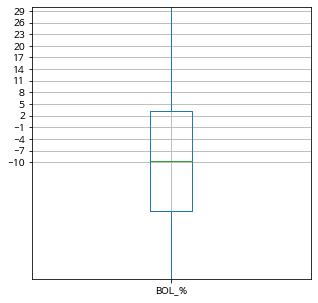

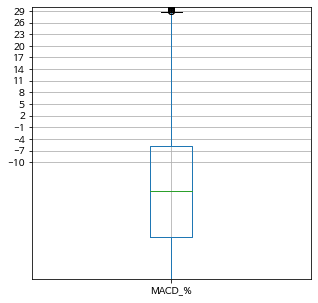

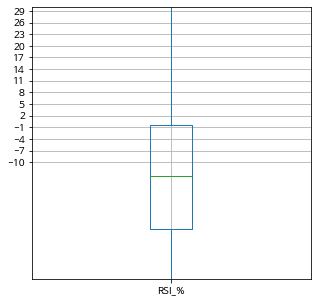

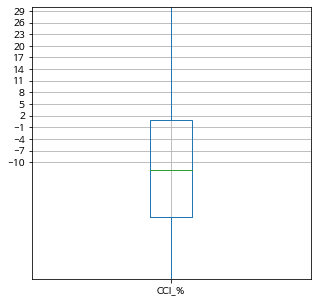

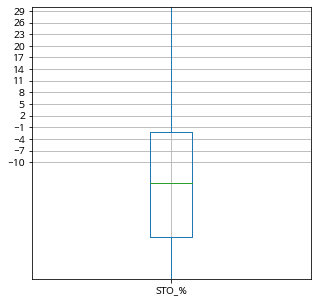

In [269]:
# 수익률 %로 환산


a = [0]*(len(data[data['종목명'] == data['종목명'][0]])-1)
b = [1]
c = (a+b)*int(len(data)/(len(data[data['종목명'] == data['종목명'][0]])))

data['out_%'] = c
data_out = data[data['out_%'] == 1]

#data_out = data_out.reset_index(drop=False, inplace = False)

q3 = data_out.quantile(0.75)
q1 = data_out.quantile(0.25)

iqr = q3 - q1

def is_outlier(df):
    indicator = "BOL_%"
    score = df[indicator]
    if score > q3[indicator] +1.5*iqr[indicator] or score < q1[indicator] - 1.5*iqr[indicator]:
        return True
    else:
        return False


data_out['BOL_outlier'] = data_out.apply(is_outlier, axis=1)
data_out_BOL = data_out.loc[data_out['BOL_outlier'] == False]

def is_outlier(df):
    indicator = "MACD_%"
    score = df[indicator]
    if score > q3[indicator] +1.5*iqr[indicator] or score < q1[indicator] - 1.5*iqr[indicator]:
        return True
    else:
        return False


data_out['MACD_outlier'] = data_out.apply(is_outlier, axis=1)
data_out_MACD = data_out.loc[data_out['MACD_outlier'] == False]

def is_outlier(df):
    indicator = "RSI_%"
    score = df[indicator]
    if score > q3[indicator] +1.5*iqr[indicator] or score < q1[indicator] - 1.5*iqr[indicator]:
        return True
    else:
        return False


data_out['RSI_outlier'] = data_out.apply(is_outlier, axis=1)
data_out_RSI = data_out.loc[data_out['RSI_outlier'] == False]

def is_outlier(df):
    indicator = "CCI_%"
    score = df[indicator]
    if score > q3[indicator] +1.5*iqr[indicator] or score < q1[indicator] - 1.5*iqr[indicator]:
        return True
    else:
        return False


data_out['CCI_outlier'] = data_out.apply(is_outlier, axis=1)
data_out_CCI = data_out.loc[data_out['CCI_outlier'] == False]

def is_outlier(df):
    indicator = "STO_%"
    score = df[indicator]
    if score > q3[indicator] +1.5*iqr[indicator] or score < q1[indicator] - 1.5*iqr[indicator]:
        return True
    else:
        return False


data_out['STO_outlier'] = data_out.apply(is_outlier, axis=1)
data_out_STO = data_out.loc[data_out['STO_outlier'] == False]

import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize = (5,5))
boxplot = data_out_BOL.boxplot(column = ['BOL_%'])
plt.yticks(np.arange(-10, 30, step=3))
plt.ylim([-40, 30])
#plt.show
print(data_out_BOL['BOL_%'].mean())

import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize = (5,5))
boxplot = data_out_MACD.boxplot(column = ['MACD_%'])
plt.yticks(np.arange(-10, 30, step=3))
plt.ylim([-40, 30])
#plt.show
print(data_out_MACD['MACD_%'].mean())

import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize = (5,5))
boxplot = data_out_RSI.boxplot(column = ['RSI_%'])
plt.yticks(np.arange(-10, 30, step=3))
plt.ylim([-40, 30])
#plt.show
print(data_out_RSI['RSI_%'].mean())

import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize = (5,5))
boxplot = data_out_CCI.boxplot(column = ['CCI_%'])
plt.yticks(np.arange(-10, 30, step=3))
plt.ylim([-40, 30])
#plt.show

print(data_out_CCI['CCI_%'].mean())

import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize = (5,5))
boxplot = data_out_STO.boxplot(column = ['STO_%'])
plt.yticks(np.arange(-10, 30, step=3))
plt.ylim([-40, 30])
#plt.show
print(data_out_STO['STO_%'].mean())

In [270]:
data_out_STO['STO_%'].min()

-69.83276000000001

In [271]:
data['STO_%'].max()

296.5167333333334

In [272]:
sample = trade_data[trade_data['종목명'] == 'NH투자증권']
sample = sample.drop(['level_0'], axis = 1)
sample = sample.reset_index(drop=False, inplace = False)

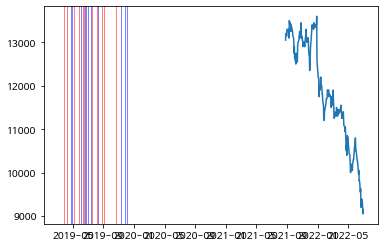

In [273]:
import pandas as pd
from datetime import datetime
#from pandas_datareader import data

sample = sample.set_index("날짜")

from datetime import timedelta
from datetime import datetime

sample_1['날짜']= sample_1['날짜'].astype('str')
for i in range(len(sample_1)):
    str_1 = sample_1['날짜'][i]
    str_y = str_1[:4]
    str_m = str_1[5:7]
    str_d = str_1[8:10]
    span_start = datetime(int(str_y), int(str_m), int(str_d))
    span_end = span_start + timedelta(days=1)
    plt.axvspan(span_start, span_end, facecolor='red', alpha=0.5)
    
    
sample_2['날짜']= sample_2['날짜'].astype('str')
for i in range(len(sample_2)):
    str_1 = sample_2['날짜'][i]
    str_y = str_1[:4]
    str_m = str_1[5:7]
    str_d = str_1[8:10]
    span_start = datetime(int(str_y), int(str_m), int(str_d))
    span_end = span_start + timedelta(days=1)
    plt.axvspan(span_start, span_end, facecolor='blue', alpha=0.5)

plt.plot(sample['Close'])

In [274]:
sample_1 = sample[sample['STO_trade'] == 1] # 매수 사인이 나온 인덱스
sample_2 = sample[sample['STO_trade'] == 2] # 매도 사인이 나온 인덱스 

sample_1 = sample_1.drop(['level_0'], axis = 1)
sample_2 = sample_2.drop(['level_0'], axis = 1)

sample_1 = sample_1.reset_index(drop=False, inplace = False)
sample_2 = sample_2.reset_index(drop=False, inplace = False)

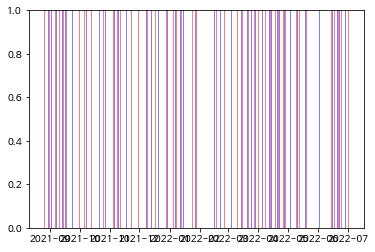

In [275]:
from datetime import timedelta
from datetime import datetime

sample_1['날짜']= sample_1['날짜'].astype('str')
for i in range(len(sample_1)):
    str_1 = sample_1['날짜'][i]
    str_y = str_1[:4]
    str_m = str_1[5:7]
    str_d = str_1[8:10]
    span_start = datetime(int(str_y), int(str_m), int(str_d))
    span_end = span_start + timedelta(days=1)
    plt.axvspan(span_start, span_end, facecolor='red', alpha=0.5)
    
    
sample_2['날짜']= sample_2['날짜'].astype('str')
for i in range(len(sample_2)):
    str_1 = sample_2['날짜'][i]
    str_y = str_1[:4]
    str_m = str_1[5:7]
    str_d = str_1[8:10]
    span_start = datetime(int(str_y), int(str_m), int(str_d))
    span_end = span_start + timedelta(days=1)
    plt.axvspan(span_start, span_end, facecolor='blue', alpha=0.5)

In [116]:
sample_1.dtypes
sample_1['날짜']= sample_1['날짜'].astype('str')

In [141]:
# 맞추면 m 틀리면 y 
count1 = 0
count2 = 0
for i in range(len(sample)-1):
    if sample['STO_trade'][i] == 1: # 매수신호 
        if sample['trend'][i+1] == 1:
            count1 += 1
        elif sample['trend'][i+1] == -1:
            count2 += 1
    elif sample['STO_trade'][i] == 2: # 매도신호
        if sample['trend'][i+1] == -1:
            count1 += 1
        elif sample['trend'][i+1] == 1:
            count2 += 1
            
print(count1, count2)

73 2


In [190]:
sample_1['trend']

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     0
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
22    1
23   -1
24    1
25    1
26    1
27    1
28    1
29    1
30    1
31    1
32    1
33    1
34    0
35    1
36    1
37    1
38    1
39    1
Name: trend, dtype: int64

In [146]:
sample['STO_trade'][0]

0

In [150]:
ss = sample['STO_trade']
ss[:50]

날짜
2019-03-05    0
2019-03-06    0
2019-03-07    2
2019-03-08    0
2019-03-11    1
2019-03-12    0
2019-03-13    0
2019-03-14    0
2019-03-15    0
2019-03-18    0
2019-03-19    2
2019-03-20    1
2019-03-21    0
2019-03-22    2
2019-03-25    0
2019-03-26    0
2019-03-27    0
2019-03-28    0
2019-03-29    1
2019-04-01    0
2019-04-02    0
2019-04-03    0
2019-04-04    2
2019-04-05    1
2019-04-08    2
2019-04-09    0
2019-04-10    1
2019-04-11    0
2019-04-12    2
2019-04-15    1
2019-04-16    2
2019-04-17    0
2019-04-18    0
2019-04-19    0
2019-04-22    0
2019-04-23    0
2019-04-24    0
2019-04-25    1
2019-04-26    2
2019-04-29    1
2019-04-30    2
2019-05-02    0
2019-05-03    0
2019-05-07    0
2019-05-08    1
2019-05-09    2
2019-05-10    0
2019-05-13    0
2019-05-14    1
2019-05-15    0
Name: STO_trade, dtype: int64

In [152]:
sss = sample['trend']
sss[:50]

날짜
2019-03-05    0
2019-03-06    0
2019-03-07   -1
2019-03-08   -1
2019-03-11    1
2019-03-12    1
2019-03-13   -1
2019-03-14    1
2019-03-15    1
2019-03-18    1
2019-03-19   -1
2019-03-20    1
2019-03-21    1
2019-03-22   -1
2019-03-25   -1
2019-03-26    1
2019-03-27   -1
2019-03-28   -1
2019-03-29    1
2019-04-01    1
2019-04-02    1
2019-04-03    1
2019-04-04   -1
2019-04-05    1
2019-04-08   -1
2019-04-09   -1
2019-04-10    1
2019-04-11   -1
2019-04-12    0
2019-04-15    1
2019-04-16   -1
2019-04-17    1
2019-04-18   -1
2019-04-19    0
2019-04-22    1
2019-04-23   -1
2019-04-24   -1
2019-04-25    1
2019-04-26   -1
2019-04-29    1
2019-04-30   -1
2019-05-02    1
2019-05-03   -1
2019-05-07   -1
2019-05-08    1
2019-05-09   -1
2019-05-10    1
2019-05-13   -1
2019-05-14    0
2019-05-15    1
Name: trend, dtype: int64